In [1]:
import sklearn
import numpy as np
import os

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Clustering

## Classification _vs_ Clustering

In [2]:
from sklearn.datasets import load_iris

In [3]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

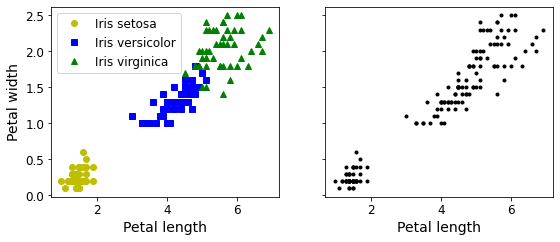

In [4]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

Дане зображення ілюструє різницю даних у задачах класифікації та кластеризації: у першому випадку відгуки є відомими (для навчальної вибірки), а у другому - ні.

Застосуємо Gaussian mixture model. Вона розбиває дані на кластери досить близько до значення класів.

In [5]:
from sklearn.mixture import GaussianMixture

In [6]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)
mapping = np.array([1, 2, 0])
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

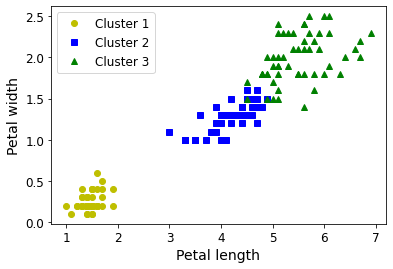

In [7]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [8]:
np.sum(y_pred==y)

145

In [9]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

## K-Means

Почнемо з генерації датасету:

In [10]:
from sklearn.datasets import make_blobs

In [11]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [12]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

Візуалізуємо:

In [13]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

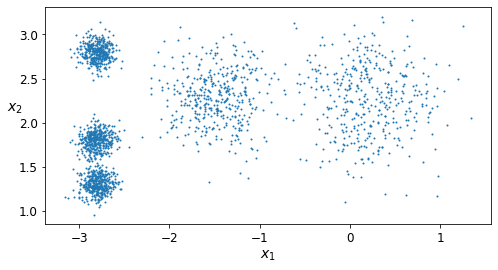

In [14]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

### Натренуємо K-Means

In [15]:
from sklearn.cluster import KMeans

In [16]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Кожний елемент був асоційованим з одним з 5 кластерів:

In [17]:
y_pred

array([0, 4, 1, ..., 2, 1, 4], dtype=int32)

kmeans.labels_ містить id кластерів, асоційованих з елементами тренувальної вибірки:

In [18]:
y_pred is kmeans.labels_

True

Центроїди кластерів:

In [19]:
kmeans.cluster_centers_

array([[-2.80037642,  1.30082566],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80389616,  1.80117999]])

Звісно, ми також можемо асоціювати нові дані з існуючими кластерами шляхом знаходження найближчого центроїда:

In [20]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

### Межі рішень

Межі рішень утворюють _діаграму Вороного_:

In [21]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

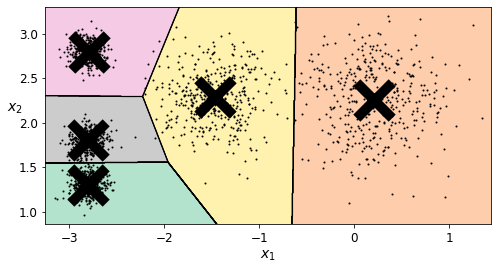

In [22]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

### Hard Clustering _vs_ Soft Clustering

Замість присвоєння кластера елементу вибірки, ми могли б порівняти відстані до відповідних центрів, і таким чином отримати т.з. м'яку кластеризацію. Для цього використаємо функцію `transform()`:

In [23]:
kmeans.transform(X_new)

array([[2.88633901, 0.32995317, 2.9042344 , 1.49439034, 2.81093633],
       [5.84236351, 2.80290755, 5.84739223, 4.4759332 , 5.80730058],
       [1.71086031, 3.29399768, 0.29040966, 1.69136631, 1.21475352],
       [1.21567622, 3.21806371, 0.36159148, 1.54808703, 0.72581411]])

Дійсно, це відстань до центроїдів:

In [24]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.88633901, 0.32995317, 2.9042344 , 1.49439034, 2.81093633],
       [5.84236351, 2.80290755, 5.84739223, 4.4759332 , 5.80730058],
       [1.71086031, 3.29399768, 0.29040966, 1.69136631, 1.21475352],
       [1.21567622, 3.21806371, 0.36159148, 1.54808703, 0.72581411]])

### Вплив ініціалізації на K-Means

In [25]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

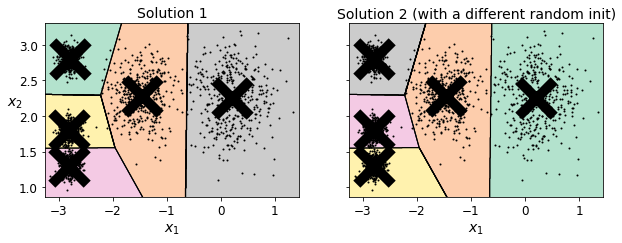

In [26]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=19)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

plt.show()

### Інерція

Для порівняння розбиттів на кластери введемо метрику, що називається інерція: суму відстаней від елементів до центроїдів відповідних кластерів:

In [27]:
kmeans.inertia_

211.5985372581683

Дійсно:

In [28]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.5985372581688

Метож `score()` повертає від'ємну інерцію:

In [29]:
kmeans.score(X)

-211.5985372581683

### Оптимальна кількісьб кластерів

Розглянемо тепер кількість кластерів, відмінну від 5

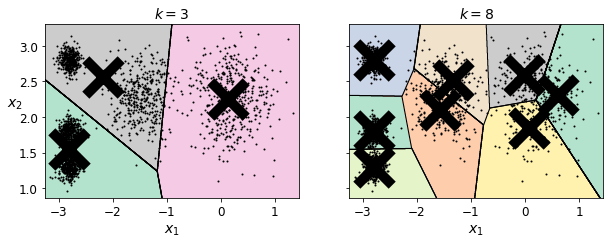

In [30]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

Обчисливо відповідну інерцію

In [31]:
kmeans_k3.inertia_

653.2223267580945

In [32]:
kmeans_k8.inertia_

118.44108623570082

Інерція лише спадатиме зі зростанням кільксті кластрів, і не може прямо слугувати для визначення оптимальної кількості кластерів. Натомість, зобразимо графік залежності інерції від кількості кластерів:

In [33]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

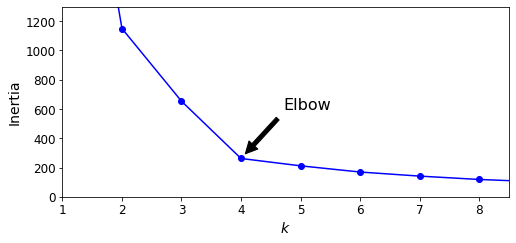

In [34]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

Як ми бачимо, цей графік має "лікоть" при $k=4$, що означає, що при подальшому збільшенні кількості кластрів інерція починає спадати повільно. Можемо припустити, що $k=4$ є хорошим наближення оптимальної кількості кластерів.

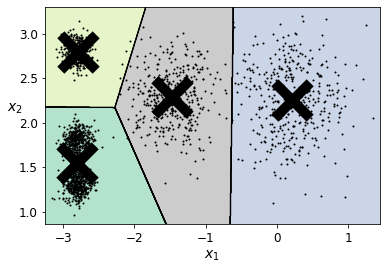

In [35]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Інша метрика - це _silhouette score_, що визначається як середнє знання _silhouette coefficient_ у датасетів. В свою чергу, silhouette coefficient елемента дорівнює $(b - a)/\max(a, b)$ де $a$ є середньою відстанню від елемента до елементів свого кластера, а $b$ є is середньою відстанню від елемента до елементів найближчого сусіднього кластера. Значення silhouette coefficient варіюється від -1 до +1.

Зобразимо silhouette score як функцію від $k$:

In [36]:
from sklearn.metrics import silhouette_score

In [37]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [38]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

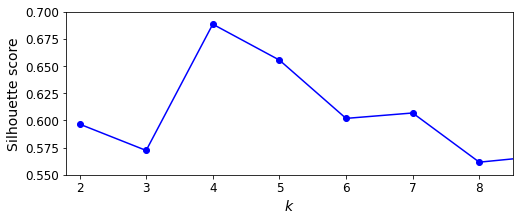

In [39]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

Дана діаграма вказує, що і $k=4$, і $k=5$ є хорошим вибором.

###  _Silhouette diagram_

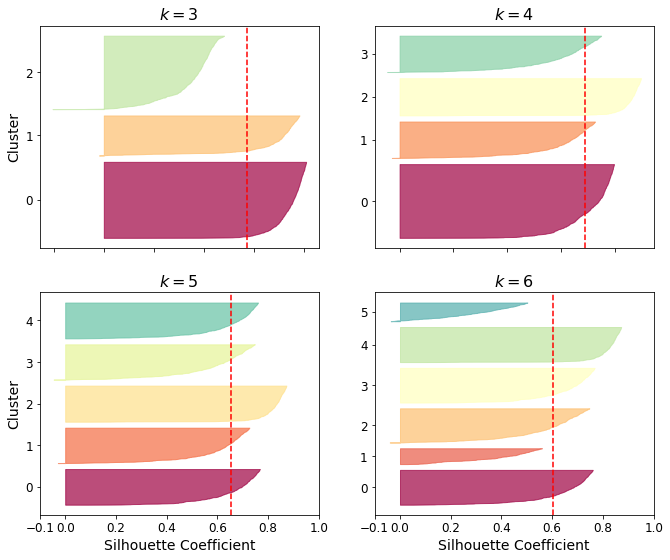

In [40]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)
    
plt.show()

### K-Means та кластери "неправильної" форми

K-Means погано справляється з близько розташованими кластерами неправильної форми, або різних розмірів

In [41]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

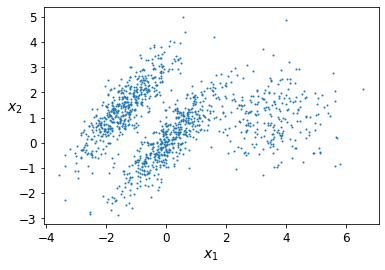

In [42]:
plot_clusters(X)

In [43]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

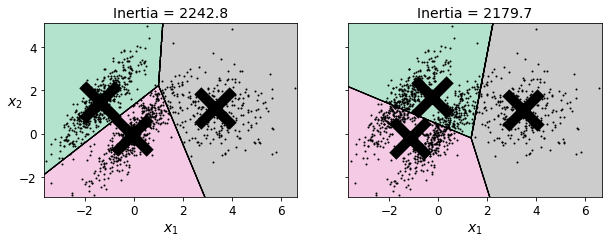

In [44]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

plt.show()

### Кластеризація для сегментації зображень

In [45]:
import urllib
filename = "ladybug.png"

url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/images/unsupervised_learning/ladybug.png"
urllib.request.urlretrieve(url,  filename)

('ladybug.png', <http.client.HTTPMessage at 0x7fa21c9790d0>)

In [46]:
from matplotlib.image import imread
image = imread(filename)
image.shape

(533, 800, 3)

In [47]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [48]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

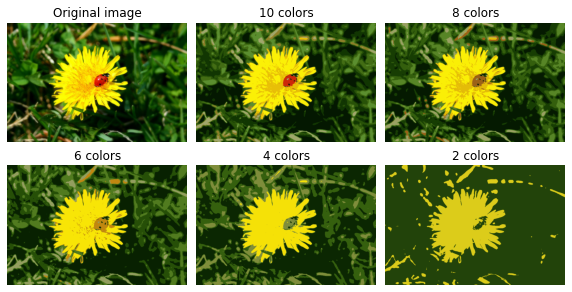

In [49]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')
plt.show()

# Gaussian Mixtures

In [50]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

Натренуємо GMM:

In [51]:
from sklearn.mixture import GaussianMixture

In [52]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Параметри моделі:

In [53]:
gm.weights_

array([0.39054348, 0.2093669 , 0.40008962])

In [54]:
gm.means_

array([[ 0.05224874,  0.07631976],
       [ 3.40196611,  1.05838748],
       [-1.40754214,  1.42716873]])

In [55]:
gm.covariances_

array([[[ 0.6890309 ,  0.79717058],
        [ 0.79717058,  1.21367348]],

       [[ 1.14296668, -0.03114176],
        [-0.03114176,  0.9545003 ]],

       [[ 0.63496849,  0.7298512 ],
        [ 0.7298512 ,  1.16112807]]])

Чи алгоритм збігся?

In [56]:
gm.converged_

True

За скільки ітерацій?

In [57]:
gm.n_iter_

4

Знайдемо асоціацію елементів з розподілами з суміші (що можуть розглядатися як кластери):

In [58]:
gm.predict(X)

array([0, 0, 2, ..., 1, 1, 1])

In [59]:
gm.predict_proba(X)

array([[9.77227791e-01, 2.27715290e-02, 6.79898914e-07],
       [9.83288385e-01, 1.60345103e-02, 6.77104389e-04],
       [7.51824662e-05, 1.90251273e-06, 9.99922915e-01],
       ...,
       [4.35053542e-07, 9.99999565e-01, 2.17938894e-26],
       [5.27837047e-16, 1.00000000e+00, 1.50679490e-41],
       [2.32355608e-15, 1.00000000e+00, 8.21915701e-41]])

Можемо синтезувати нові елементи згідно з отриманим розподілом:

In [60]:
X_new, y_new = gm.sample(6)
X_new

array([[-0.8690223 , -0.32680051],
       [ 0.29945755,  0.2841852 ],
       [ 1.85027284,  2.06556913],
       [ 3.98260019,  1.50041446],
       [ 3.82006355,  0.53143606],
       [-1.04015332,  0.7864941 ]])

In [61]:
y_new

array([0, 0, 1, 1, 1, 2])

Можна також отримати логарифм фунції щільності за допомогою функції `score_samples()` :

In [62]:
gm.score_samples(X)

array([-2.60674489, -3.57074133, -3.33007348, ..., -3.51379355,
       -4.39643283, -3.8055665 ])

Зобразимо межі рішень та контури функції щільності:

In [63]:
from matplotlib.colors import LogNorm

resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()


def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

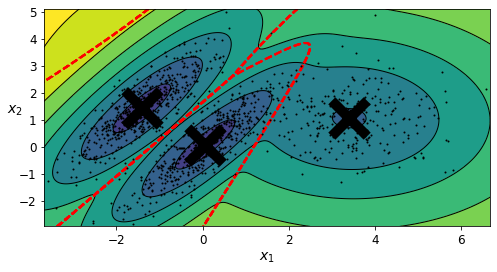

In [64]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.show()

Ми можемо накладати умови на матриці коваріації за допомогою параметру `covariance_type`:

In [65]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

In [66]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)


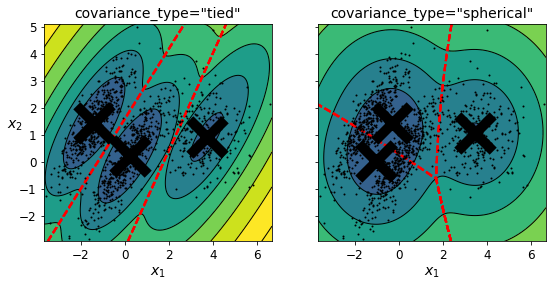

In [67]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)
plt.show()

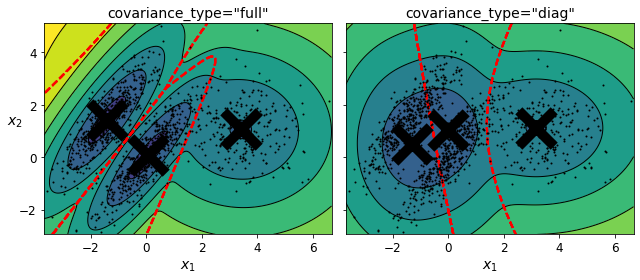

In [68]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

## Виявлення аномалій за допомогою GMM

GMM можна використати для виявлення аномалій: елементи у областях малої щільності можуть вважатися аномальними. Наприклад, знайдемо поріг функції щільності такий, що 4% елементів знаходять за порогом:

In [69]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

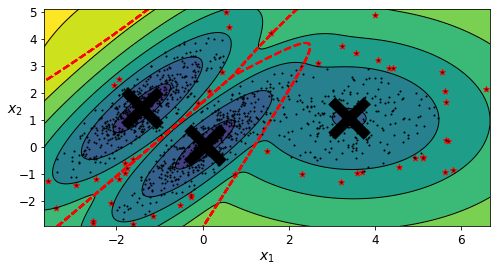

In [70]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

plt.show()

# Завдання

In [71]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
import seaborn as sns

In [72]:
np.random.seed(42)
sns.set(style='whitegrid')

*Завдання 1: Завантажте MNIST. Розбийте його на навчальну, валідаційну та тренувальну вибірку. Застосуйте PCA для зменшення розмірності.*

In [73]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [74]:
X_train, X_val, X_test = X[:50000], X[50000:60000], X[60000:]
y_train, y_val, y_test = y[:50000], y[50000:60000], y[60000:]

In [75]:
np.unique(y_train, return_counts=True)

(array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object),
 array([4932, 5678, 4968, 5101, 4859, 4506, 4951, 5175, 4842, 4988]))

In [76]:
pca = PCA(n_components=0.98)

X_train = pca.fit_transform(X_train)
X_val, X_test = pca.transform(X_val), pca.transform(X_test)
X_train.shape

(50000, 261)

*Завдання 2: Кластеризуйте датасет, використовуючи K-Means. Знайдіть оптимальну кількість кластерів*

In [77]:
k_clusters = [i for i in range(2,20, 4)]
print(k_clusters)
kmeans_per_k = [KMeans(n_clusters=k).fit(X_train)
                for k in k_clusters]

[2, 6, 10, 14, 18]


Text(0, 0.5, 'inertia')

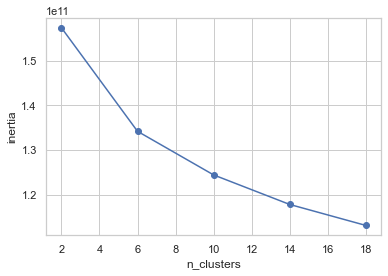

In [78]:
inertias = [model.inertia_ for model in kmeans_per_k]
plt.plot(k_clusters, inertias, "bo-")
plt.xlabel('n_clusters')
plt.ylabel('inertia')

Looks like 10 is elbow.

Text(0, 0.5, 'silhouette_scores')

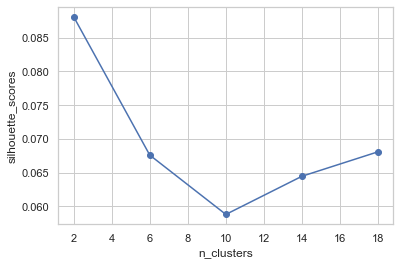

In [79]:
silhouette_scores = [silhouette_score(X_train, model.labels_)
                     for model in kmeans_per_k]
plt.plot(k_clusters, silhouette_scores, "bo-")
plt.xlabel('n_clusters')
plt.ylabel('silhouette_scores')

Silhouette score gives us completely different results. But I'm going to choose $k$=10 because there are 10 digits and it seems to be logical.

*Завдання 3: Натренуйте GMM.*

In [80]:
gmm = GaussianMixture(n_components=10, n_init = 10, max_iter=600, verbose_interval = 50, verbose=100)
gmm.fit(X_train)

Initialization 0
  Iteration 50	 time lapse 120.53301s	 ll change 0.13785
  Iteration 100	 time lapse 116.84725s	 ll change 0.00610
Initialization converged: True	 time lapse 316.29813s	 ll -1195.96636
Initialization 1
  Iteration 50	 time lapse 122.03648s	 ll change 0.12412
Initialization converged: True	 time lapse 175.97951s	 ll -1193.77535
Initialization 2
  Iteration 50	 time lapse 120.26791s	 ll change 0.13088
Initialization converged: True	 time lapse 176.65287s	 ll -1193.76720
Initialization 3
  Iteration 50	 time lapse 119.01980s	 ll change 0.07240
Initialization converged: True	 time lapse 150.51017s	 ll -1195.98799
Initialization 4
  Iteration 50	 time lapse 124.45429s	 ll change 0.12075
Initialization converged: True	 time lapse 179.11163s	 ll -1193.76981
Initialization 5
  Iteration 50	 time lapse 125.15688s	 ll change 0.03632
Initialization converged: True	 time lapse 200.95146s	 ll -1188.11360
Initialization 6
  Iteration 50	 time lapse 130.10282s	 ll change 0.11598
Init

GaussianMixture(max_iter=600, n_components=10, n_init=10, verbose=100,
                verbose_interval=50)

*Завдання 4: Синтезуйте нові елементи вибірки, використовуючи GMM. Візуалізуйте їх.*

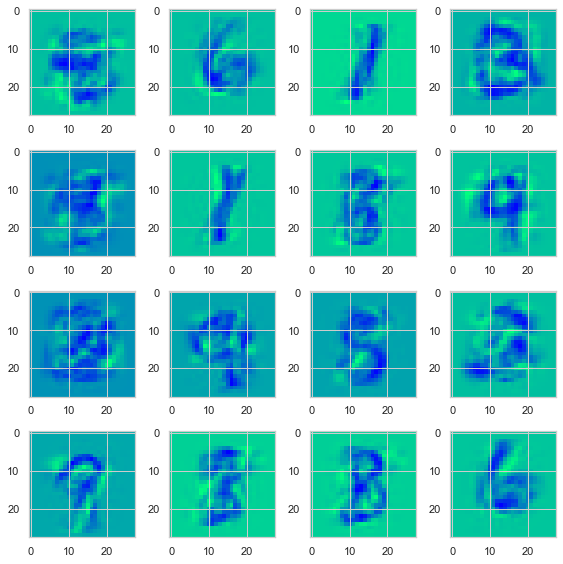

In [81]:
plt.figure(figsize=(8, 8))
for i in range(16):
    X_sample, y_sample = gmm.sample()
    X_sample = pca.inverse_transform(X_sample)
    plt.subplot(4,4,1+i)
    plt.imshow(X_sample.reshape(28, 28), cmap='winter_r')
plt.tight_layout()

Some generated digits are easy to distinguish, but most of them are not that good.